Epoch 0, Loss: 12739.80078125, Time: 0.53 seconds
Predicted States at Epoch 0: Glucose (G) = 320.0185, Insulin Action (X) = 97.6396, Insulin (I) = 37.6398


/home/simone/.miniforge3/envs/PINN310/lib/python3.10/site-packages/torchdiffeq/_impl/misc.py:296: UserWarning: t is not on the same device as y0. Coercing to y0.device.
  warnings.warn("t is not on the same device as y0. Coercing to y0.device.")


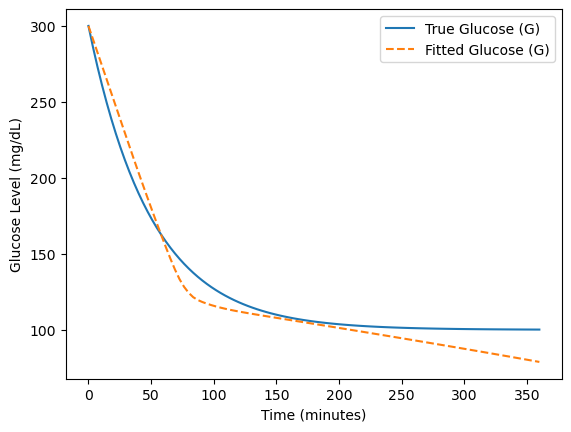

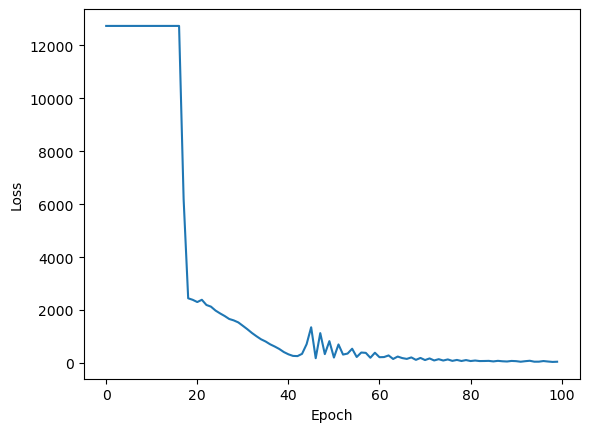

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchdiffeq import odeint
import numpy as np
import matplotlib.pyplot as plt
import time  # To track time
from torch.amp import autocast, GradScaler  # Mixed-precision utilities

# True dynamics based on the Bergman Minimal Model (used for generating data)
class BergmanTrueDynamics(nn.Module):
    def __init__(self, p1, p2, p3, G_b, I_b):
        super(BergmanTrueDynamics, self).__init__()
        self.p1 = p1
        self.p2 = p2
        self.p3 = p3
        self.G_b = G_b
        self.I_b = I_b

    def forward(self, t, state):
        G, X, I = state  # Glucose, Insulin Action, Insulin
        dGdt = -self.p1 * (G - self.G_b) - X * G
        dXdt = -self.p2 * X + self.p3 * (I - self.I_b)
        dIdt = torch.tensor(0.0)  # Insulin is assumed constant for simplicity
        return torch.stack([dGdt, dXdt, dIdt])

# Neural ODE function to fit the dynamics
class NeuralODEFunc(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(NeuralODEFunc, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, input_dim)
        )

    def forward(self, t, y):
        return self.net(y)

# Generate synthetic data from the true Bergman model
def generate_data(model, time_span, G0, X0, I0):
    initial_state = torch.tensor([G0, X0, I0], dtype=torch.float32)
    time_points = torch.linspace(0, time_span, steps=100)
    with torch.no_grad():
        true_solution = odeint(model, initial_state, time_points)
    return time_points, true_solution

# Loss function: Mean Squared Error between predicted and true values
def loss_function(predicted, true):
    return ((predicted - true)**2).mean()

# Training function with GPU, mixed precision, and time tracking
def train(ode_func, time_points, true_solution, optimizer, epochs=1000):
    losses = []
    device_name = "cuda" if torch.cuda.is_available() else "CPU"

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    ode_func.to(device)
    time_points = time_points.to(device)
    true_solution = true_solution.to(device)

    scaler = GradScaler()  # Initialize the gradient scaler for mixed precision

    start_time = time.time()  # Record the start time

    for epoch in range(epochs):
        optimizer.zero_grad()

        # Use autocast for mixed precision during forward pass and loss computation
        with autocast(device_type=device_name):
            predicted_solution = odeint(ode_func, true_solution[0], time_points, method='rk4')
            loss = loss_function(predicted_solution, true_solution)

        # Scale the loss and backward pass for mixed precision
        scaler.scale(loss).backward()

        # Step the optimizer using the scaled gradients
        scaler.step(optimizer)
        scaler.update()

        losses.append(loss.item())

        # Print loss, time, and all states every 100 epochs
        if epoch % 100 == 0:
            elapsed_time = time.time() - start_time  # Calculate elapsed time
            G_pred, X_pred, I_pred = predicted_solution[-1].cpu().detach().numpy()  # Get last state
            print(f"Epoch {epoch}, Loss: {loss.item()}, Time: {elapsed_time:.2f} seconds")
            print(f"Predicted States at Epoch {epoch}: Glucose (G) = {G_pred:.4f}, Insulin Action (X) = {X_pred:.4f}, Insulin (I) = {I_pred:.4f}")
            start_time = time.time()  # Reset the start time for the next 100 epochs

    return losses

# Main script
if __name__ == "__main__":
    # Parameters for the Bergman Minimal Model
    G_b = 100.0  # Basal glucose level (mg/dL)
    I_b = 15.0   # Basal insulin level (uU/mL)
    p1 = 0.02    # Parameter for glucose decay
    p2 = 0.025   # Parameter for insulin action decay
    p3 = 0.0001  # Parameter for insulin sensitivity

    # Initial conditions (initial glucose, insulin action, insulin)
    G0 = 300.0   # Initial glucose level (mg/dL)
    X0 = 0.0     # Initial insulin action
    I0 = 15.0    # Initial insulin level (uU/mL)
    time_span = 360  # Simulate for 180 minutes

    # Create the true Bergman model for generating data
    true_model = BergmanTrueDynamics(p1=p1, p2=p2, p3=p3, G_b=G_b, I_b=I_b)

    # Generate synthetic data (true solution)
    time_points, true_solution = generate_data(true_model, time_span, G0, X0, I0)

    # Initialize the Neural ODE function (input_dim=3 for [G, X, I], hidden_dim=50)
    ode_func = NeuralODEFunc(input_dim=3, hidden_dim=50)

    # Optimizer
    optimizer = optim.Adam(ode_func.parameters(), lr=0.01)

    # Train the model and keep track of time per 100 epochs with mixed precision
    losses = train(ode_func, time_points, true_solution, optimizer, epochs=100)

    # Plot the results
    with torch.no_grad():
        predicted_solution = odeint(ode_func, true_solution[0].to('cuda'), time_points, method='rk4')
    predicted_solution = predicted_solution.cpu()
    # Plotting the true vs predicted glucose dynamics
    plt.plot(time_points.numpy(), true_solution[:, 0].numpy(), label="True Glucose (G)")
    plt.plot(time_points.numpy(), predicted_solution[:, 0].numpy(), '--', label="Fitted Glucose (G)")
    plt.xlabel('Time (minutes)')
    plt.ylabel('Glucose Level (mg/dL)')
    plt.legend()
    plt.show()

    # Plot training loss
    plt.plot(losses)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()